In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import librosa
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import pickle
from keras.callbacks import ModelCheckpoint

e:\miniconda\envs\vir_env\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
e:\miniconda\envs\vir_env\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
Using TensorFlow backend.


In [2]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=8, ncols=5, sharex=False,
                             sharey=True, figsize=(20,16))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(8):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [3]:
def plot_fft(fft):
    fig, axes = plt.subplots(nrows=8, ncols=5, sharex=False,
                             sharey=True, figsize=(20,16))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(8):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [4]:
def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=8, ncols=5, sharex=False,
                             sharey=True, figsize=(20,16))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(8):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [5]:
def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=8, ncols=5, sharex=False,
                             sharey=True, figsize=(20,16))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(8):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [6]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [7]:
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y, freq)

In [10]:
df = pd.read_csv("file_details.csv")

In [11]:
df.head()

,fname,label
0,aat (1).wav,aat
1,aat (10).wav,aat
2,aat (11).wav,aat
3,aat (12).wav,aat
4,aat (13).wav,aat


In [12]:
df.set_index('fname', inplace=True)

In [13]:
for f in df.index:
    rate, signal = wavfile.read('wavfiles/'+f)
    df.at[f,'length'] = signal.shape[0]/rate

e:\miniconda\envs\vir_env\lib\site-packages\ipykernel_launcher.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  


In [14]:
classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()
print(class_dist)

label
aat        0.935402
agerta     1.139133
aso        1.026442
baba       0.932106
bajao      1.015790
bari       0.982741
basa       1.109801
bhai       0.928293
bon        0.959768
boro       1.014569
caar       0.938667
cacha      0.970345
cachi      0.988237
chalao     0.997736
choi       0.957145
choto      0.952374
dekhao     1.069596
dhire      0.979625
dosh       0.975361
dui        0.973608
ek         0.868648
ghumao     1.018368
gorom      1.078734
ha         1.068668
jago       1.055138
jao        0.990934
ma         0.917492
na         0.970349
niche      0.986173
noi        0.936843
norom      0.987721
pach       0.962292
pashe      1.022787
porerta    1.035013
shamne     1.046397
shat       0.948366
shokto     1.084622
shunno     0.989328
thanda     0.992642
tin        0.929452
Name: length, dtype: float64


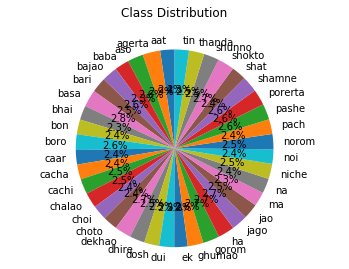

In [15]:
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist,labels=class_dist.index,autopct='%1.1f%%',shadow=False,startangle=90)
ax.axis('equal')
plt.show()

In [16]:
df.reset_index(inplace=True)

In [17]:
signals = {} 
fft = {}
fbank = {}
mfccs = {}

In [19]:
for c in classes:
    wav_file = df[df.label == c].iloc[0,0]
    signal, rate = librosa.load('wavfiles/'+wav_file, sr=44100)
    mask = envelope(signal, rate, 0.0005)
    signal = signal[mask]
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)

    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T
    fbank[c] = bank
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
    mfccs[c] = mel

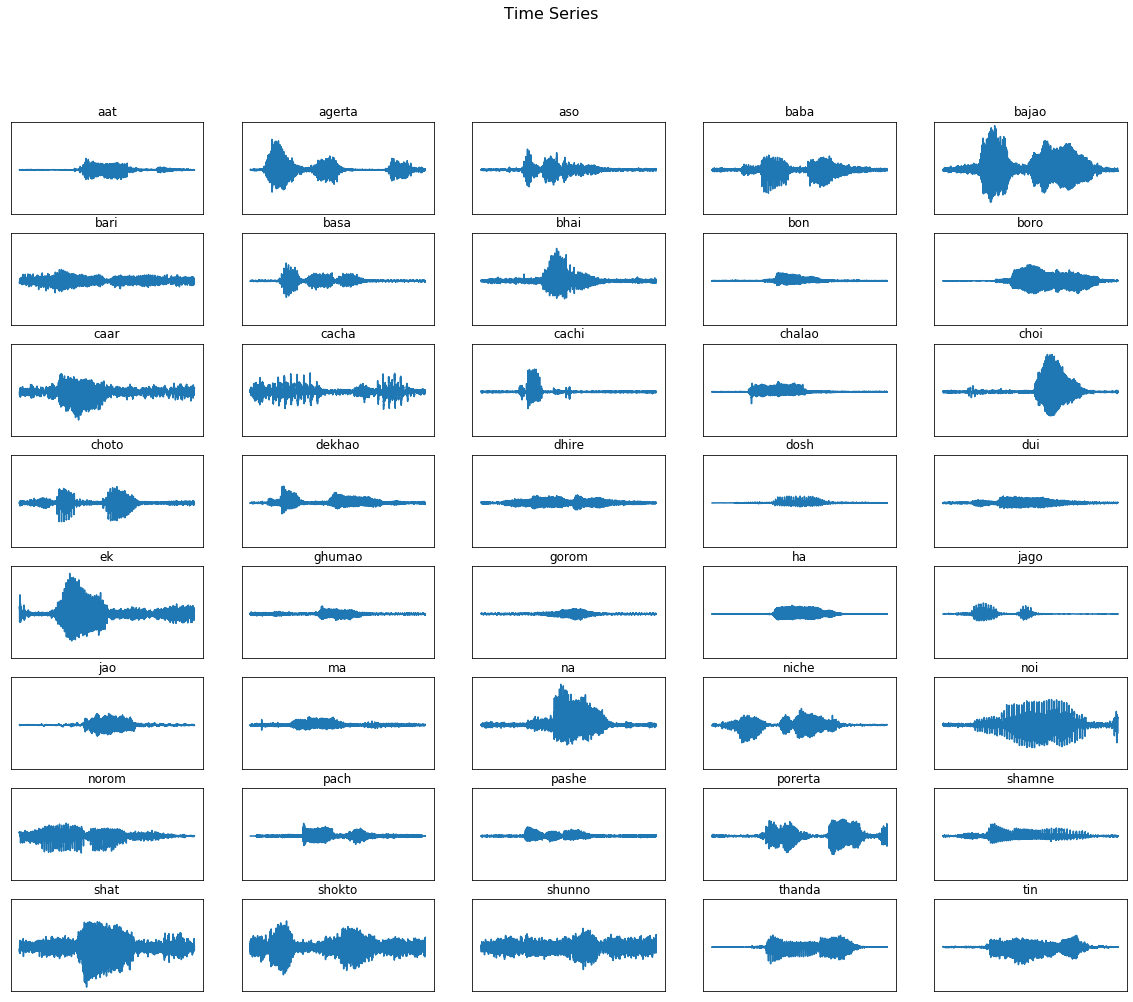

In [20]:
plot_signals(signals)
plt.show()

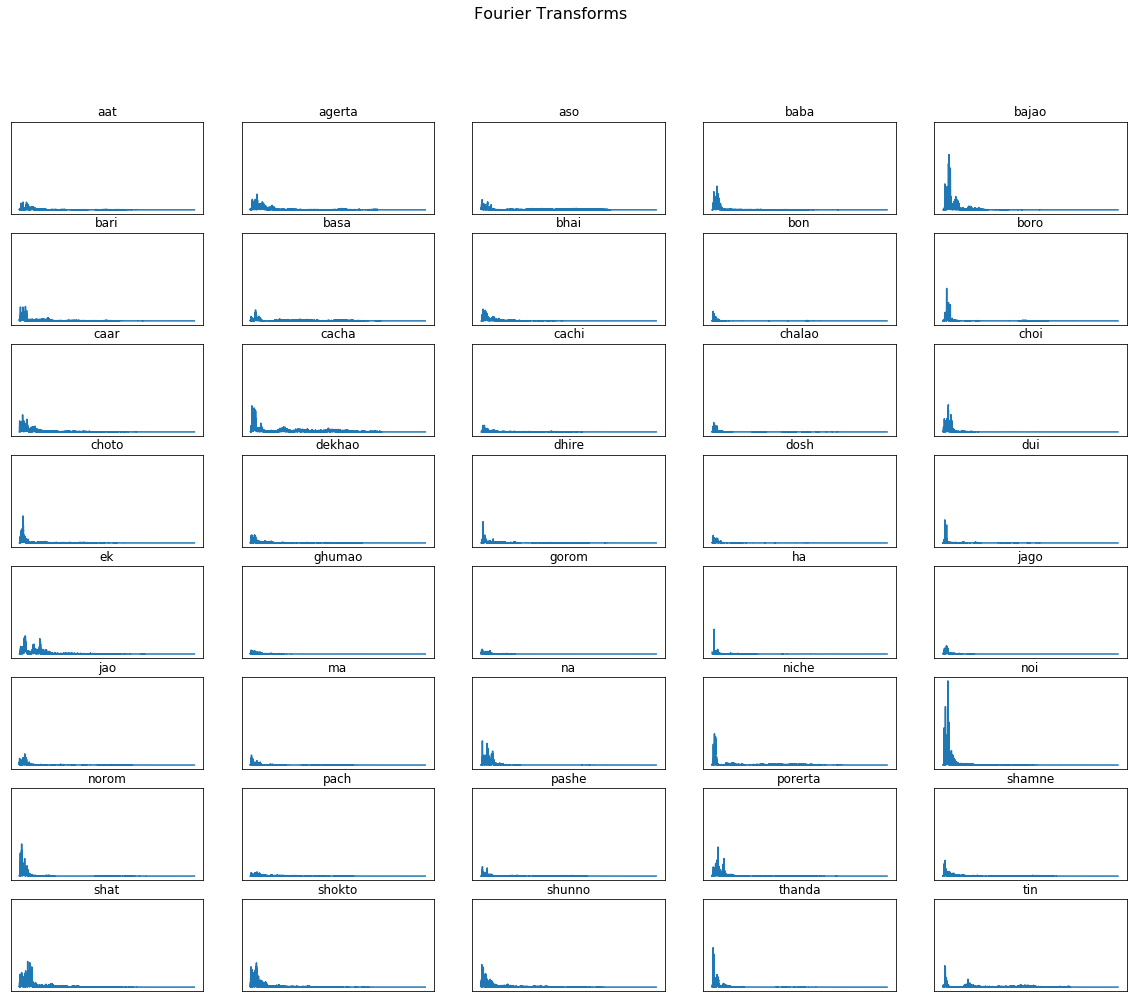

In [60]:
plot_fft(fft)
plt.show()

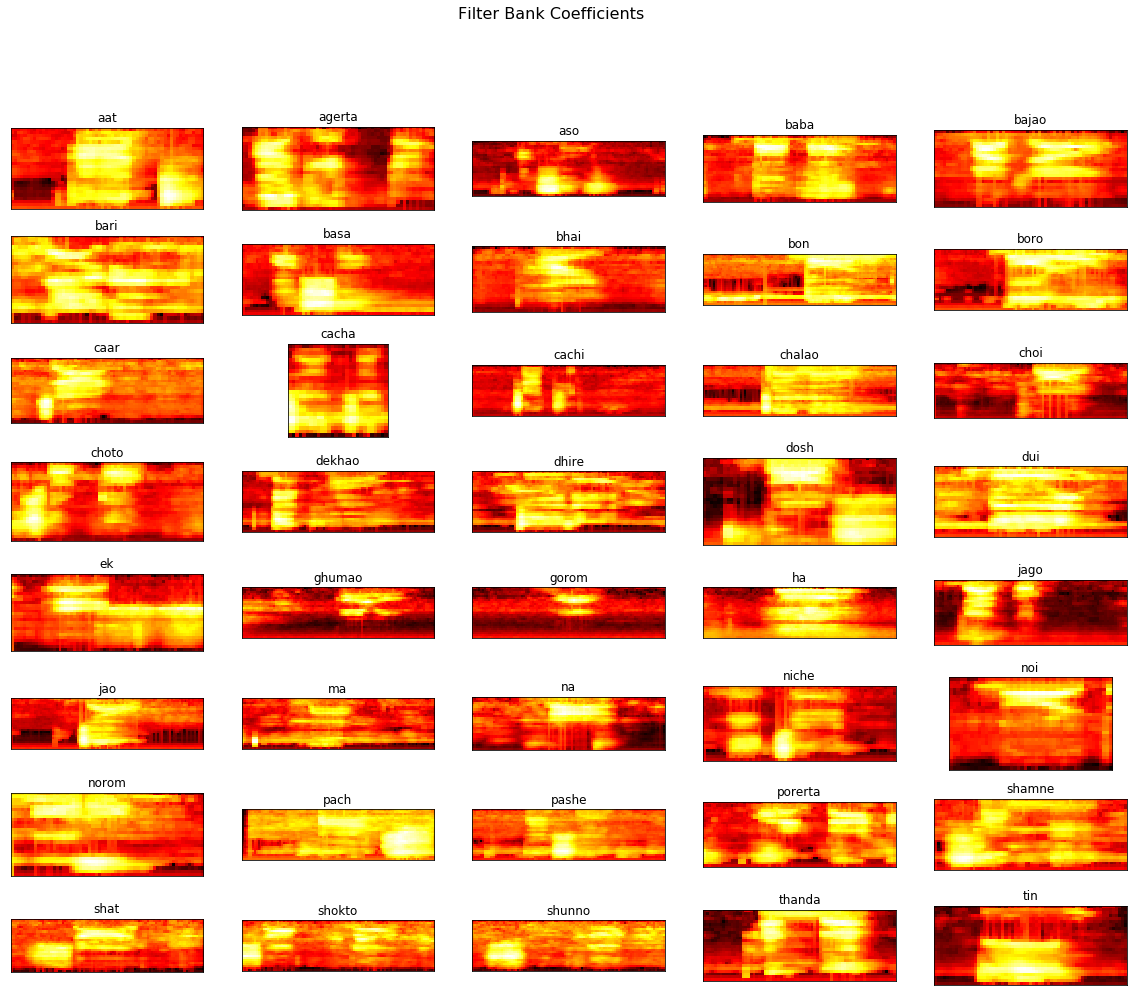

In [61]:
plot_fbank(fbank)
plt.show()

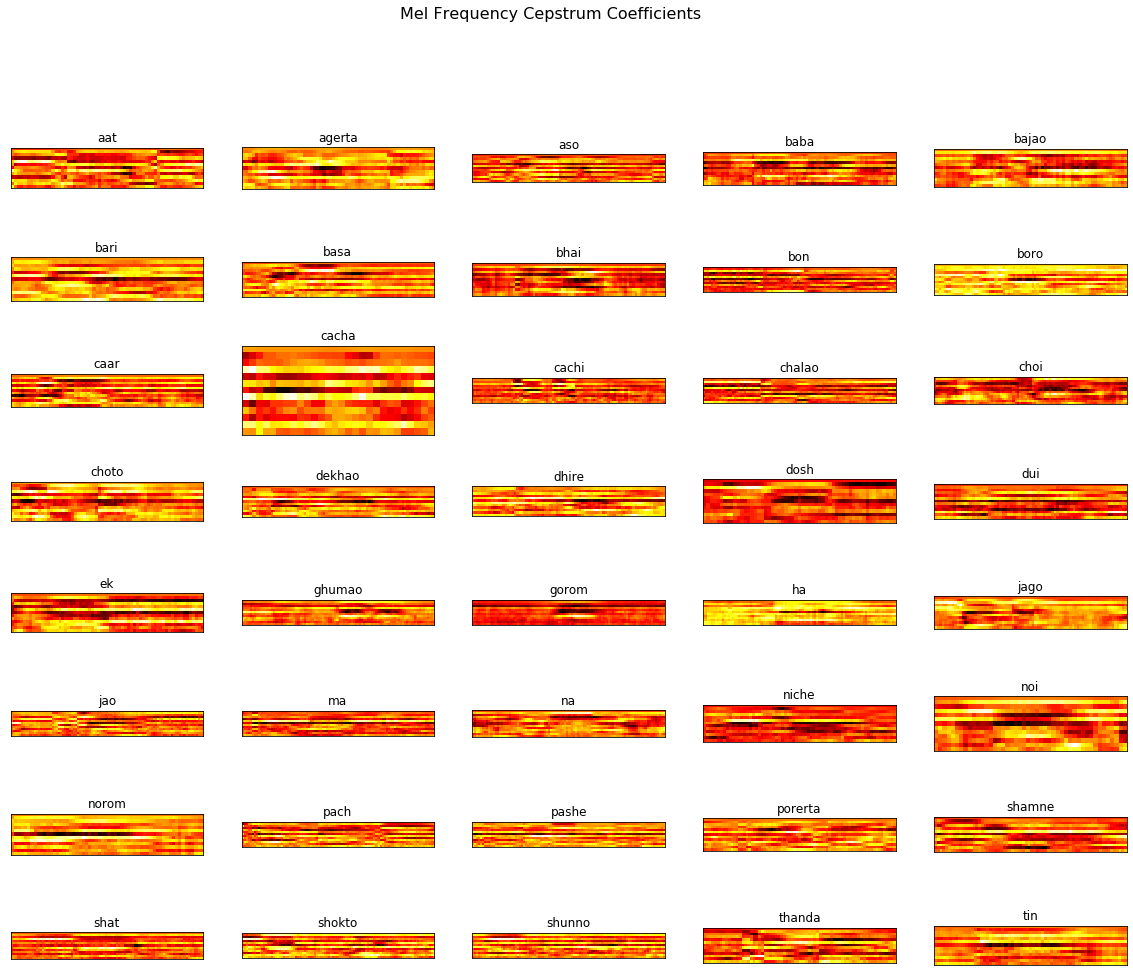

In [65]:
plot_mfccs(mfccs)
plt.show()

In [71]:
if len(os.listdir('clean')) == 0:
    for f in tqdm(df.fname):
        signal, rate = librosa.load('wavfiles/'+f, sr=16000)
        mask = envelope(signal, rate, 0.0005)
        wavfile.write(filename='clean/'+f, rate=rate, data=signal[mask])

100%|██████████████████████████████████████████████████████████████████████████████| 3834/3834 [07:21<00:00,  8.68it/s]


In [21]:
class Config:
    def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=512, rate=16000):
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft 
        self.rate = rate
        self.step = int(rate/40)
        self.model_path = os.path.join('models', mode + '.model')
        self.p_path = os.path.join('pickles', mode + '.p')

In [22]:
def check_data():
    if os.path.isfile(config.p_path):
        print('Loading existing data for {} model'.format(config.mode))
        with open(config.p_path, 'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None

In [23]:
def build_rand_feat():
	tmp = check_data()
	if tmp:
		return tmp.data[0], tmp.data[1]
	X = []
	y = []
	_min, _max = float('inf'), -float('inf')
	for _ in tqdm(range(n_samples)):
		rand_class = np.random.choice(class_dist.index, p=prob_dist)
		file = np.random.choice(df[df.label==rand_class].index)
		rate, wav= wavfile.read('clean/'+file)
		label = df.at[file, 'label']
		rand_index = np.random.randint(0, wav.shape[0]-config.step)
		sample = wav[rand_index:rand_index+config.step]
		X_sample = mfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft)
		_min = min(np.amin(X_sample), _min)
		_max = max(np.amax(X_sample), _max)
		X.append(X_sample)
		y.append(classes.index(label))
	config.min = _min
	config.max = _max
	X, y = np.array(X), np.array(y)
	X = (X - _min) / (_max - _min)
	if config.mode == 'conv':
		X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
	elif config.mode == 'time':
		X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
	y = to_categorical(y, num_classes=40)
	config.data = (X, y)

	with open(config.p_path, 'wb') as handle:
		pickle.dump(config, handle, protocol=2)
	return X, y

In [26]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(112, (3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape))
    model.add(Conv2D(86, (3,3), activation='relu',strides=(1,1),padding='same'))
    model.add(Conv2D(64, (3,3), activation='relu',strides=(1,1),padding='same'))
    model.add(Conv2D(128, (3,3), activation='relu',strides=(1,1),padding='same'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(86,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(40,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

In [27]:
def get_recurrent_model():
    model = Sequential()
    model.add(LSTM(224, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(196, return_sequences=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(96, activation='relu')))
    model.add(TimeDistributed(Dense(86, activation='relu')))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(Flatten())
    model.add(Dense(40, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

In [28]:
df = pd.read_csv('file_details.csv')
df.set_index('fname', inplace=True)

In [29]:
for f in df.index:
    rate, signal = wavfile.read('clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

In [30]:
classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()
n_samples = 2 * int(df['length'].sum()/0.1)
prob_dist = class_dist/class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

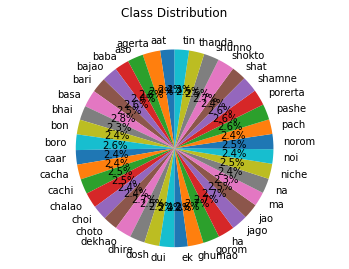

In [31]:
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [32]:
config = Config(mode='conv')
X, y = build_rand_feat()
y_flat = np.argmax(y, axis=1)
input_shape = (X.shape[1],X.shape[2],1)
model = get_conv_model()

Loading existing data for conv model
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 13, 112)        1120      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 13, 86)         86774     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 13, 64)         49600     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 13, 128)        73856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 13, 128)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1664)              0         
__

In [35]:
config = Config(mode='time')
X, y = build_rand_feat()
y_flat = np.argmax(y, axis=1)
input_shape = (X.shape[1],X.shape[2])
model = get_recurrent_model()

Loading existing data for time model
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 224)            213248    
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 196)            330064    
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 128)            166400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 96)             12384     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 86)             8342      
_________________________________________________________________
time_distributed_

In [36]:
class_weight = compute_class_weight('balanced',np.unique(y_flat),y_flat)
checkpoint = ModelCheckpoint(config.model_path,monitor='val_acc',verbose=1,mode='max',save_best_only=True,save_weights_only=False,period=1)
history = model.fit(X, y, epochs=10, batch_size=32,shuffle=True,validation_split=0.1,callbacks=[checkpoint])
model.save(config.model_path)

Train on 67858 samples, validate on 7540 samples
Epoch 1/10


25088/67858 [==========>...................] - ETA: 58:19 - loss: 3.6889 - acc: 0.0000e+ - ETA: 15:03 - loss: 3.6886 - acc: 0.0156   - ETA: 7:45 - loss: 3.6887 - acc: 0.0234 - ETA: 5:22 - loss: 3.6888 - acc: 0.023 - ETA: 4:08 - loss: 3.6888 - acc: 0.023 - ETA: 3:34 - loss: 3.6886 - acc: 0.023 - ETA: 3:10 - loss: 3.6886 - acc: 0.019 - ETA: 2:51 - loss: 3.6887 - acc: 0.018 - ETA: 2:37 - loss: 3.6887 - acc: 0.019 - ETA: 2:20 - loss: 3.6885 - acc: 0.021 - ETA: 2:11 - loss: 3.6886 - acc: 0.023 - ETA: 2:01 - loss: 3.6890 - acc: 0.021 - ETA: 1:52 - loss: 3.6888 - acc: 0.024 - ETA: 1:45 - loss: 3.6889 - acc: 0.025 - ETA: 1:39 - loss: 3.6886 - acc: 0.027 - ETA: 1:36 - loss: 3.6887 - acc: 0.026 - ETA: 1:31 - loss: 3.6890 - acc: 0.025 - ETA: 1:28 - loss: 3.6891 - acc: 0.025 - ETA: 1:24 - loss: 3.6887 - acc: 0.026 - ETA: 1:21 - loss: 3.6887 - acc: 0.027 - ETA: 1:18 - loss: 3.6889 - acc: 0.027 - ETA: 1:16 - loss: 3.6891 - acc: 0.026 - ETA: 1:13 - loss: 3.6890 - acc: 0.026 - ETA: 1:12 - loss: 3.6891

50752/67858 [=====================>........] - ETA: 23s - loss: 3.6883 - acc: 0.02 - ETA: 23s - loss: 3.6883 - acc: 0.02 - ETA: 23s - loss: 3.6883 - acc: 0.02 - ETA: 23s - loss: 3.6883 - acc: 0.02 - ETA: 23s - loss: 3.6883 - acc: 0.02 - ETA: 22s - loss: 3.6883 - acc: 0.02 - ETA: 22s - loss: 3.6883 - acc: 0.02 - ETA: 22s - loss: 3.6883 - acc: 0.02 - ETA: 22s - loss: 3.6883 - acc: 0.02 - ETA: 22s - loss: 3.6883 - acc: 0.02 - ETA: 22s - loss: 3.6883 - acc: 0.02 - ETA: 22s - loss: 3.6883 - acc: 0.02 - ETA: 22s - loss: 3.6883 - acc: 0.02 - ETA: 22s - loss: 3.6883 - acc: 0.02 - ETA: 22s - loss: 3.6883 - acc: 0.02 - ETA: 22s - loss: 3.6883 - acc: 0.02 - ETA: 22s - loss: 3.6883 - acc: 0.02 - ETA: 22s - loss: 3.6883 - acc: 0.02 - ETA: 22s - loss: 3.6883 - acc: 0.02 - ETA: 21s - loss: 3.6883 - acc: 0.02 - ETA: 21s - loss: 3.6883 - acc: 0.02 - ETA: 21s - loss: 3.6883 - acc: 0.02 - ETA: 21s - loss: 3.6882 - acc: 0.02 - ETA: 21s - loss: 3.6883 - acc: 0.02 - ETA: 21s - loss: 3.6882 - acc: 0.02 - ETA

67858/67858 [==============================] - ETA: 8s - loss: 3.6879 - acc: 0.028 - ETA: 8s - loss: 3.6879 - acc: 0.028 - ETA: 8s - loss: 3.6879 - acc: 0.028 - ETA: 8s - loss: 3.6879 - acc: 0.028 - ETA: 8s - loss: 3.6879 - acc: 0.028 - ETA: 8s - loss: 3.6879 - acc: 0.028 - ETA: 8s - loss: 3.6879 - acc: 0.028 - ETA: 8s - loss: 3.6879 - acc: 0.028 - ETA: 8s - loss: 3.6879 - acc: 0.028 - ETA: 8s - loss: 3.6879 - acc: 0.028 - ETA: 8s - loss: 3.6879 - acc: 0.028 - ETA: 8s - loss: 3.6879 - acc: 0.028 - ETA: 8s - loss: 3.6879 - acc: 0.028 - ETA: 8s - loss: 3.6879 - acc: 0.028 - ETA: 8s - loss: 3.6879 - acc: 0.028 - ETA: 7s - loss: 3.6879 - acc: 0.028 - ETA: 7s - loss: 3.6879 - acc: 0.028 - ETA: 7s - loss: 3.6879 - acc: 0.028 - ETA: 7s - loss: 3.6879 - acc: 0.028 - ETA: 7s - loss: 3.6879 - acc: 0.028 - ETA: 7s - loss: 3.6879 - acc: 0.028 - ETA: 7s - loss: 3.6879 - acc: 0.028 - ETA: 7s - loss: 3.6879 - acc: 0.028 - ETA: 7s - loss: 3.6879 - acc: 0.028 - ETA: 7s - loss: 3.6879 - acc: 0.028 - ETA

25792/67858 [==========>...................] - ETA: 54s - loss: 3.6755 - acc: 0.0000e+ - ETA: 40s - loss: 3.6827 - acc: 0.0312   - ETA: 36s - loss: 3.6828 - acc: 0.02 - ETA: 35s - loss: 3.6833 - acc: 0.02 - ETA: 34s - loss: 3.6836 - acc: 0.03 - ETA: 34s - loss: 3.6835 - acc: 0.03 - ETA: 34s - loss: 3.6848 - acc: 0.03 - ETA: 33s - loss: 3.6852 - acc: 0.03 - ETA: 34s - loss: 3.6854 - acc: 0.03 - ETA: 33s - loss: 3.6856 - acc: 0.03 - ETA: 33s - loss: 3.6864 - acc: 0.03 - ETA: 32s - loss: 3.6867 - acc: 0.03 - ETA: 32s - loss: 3.6869 - acc: 0.03 - ETA: 32s - loss: 3.6867 - acc: 0.03 - ETA: 32s - loss: 3.6870 - acc: 0.03 - ETA: 32s - loss: 3.6869 - acc: 0.03 - ETA: 32s - loss: 3.6876 - acc: 0.03 - ETA: 32s - loss: 3.6874 - acc: 0.03 - ETA: 32s - loss: 3.6870 - acc: 0.03 - ETA: 32s - loss: 3.6869 - acc: 0.03 - ETA: 32s - loss: 3.6866 - acc: 0.03 - ETA: 32s - loss: 3.6868 - acc: 0.03 - ETA: 31s - loss: 3.6870 - acc: 0.03 - ETA: 32s - loss: 3.6869 - acc: 0.03 - ETA: 31s - loss: 3.6873 - acc: 0.

51200/67858 [=====================>........] - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6872 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 19s - loss: 3.6873 - acc: 0.02 - ETA: 19s - loss: 3.6873 - acc: 0.02 - ETA: 19s - loss: 3.6873 - acc: 0.02 - ETA: 19s - loss: 3.6873 - acc: 0.02 - ETA: 19s - loss: 3.6873 - acc: 0.02 - ETA: 19s - loss: 3.6873 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6873 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6873 - acc: 0.02 - ETA: 19s - loss: 3.6873 - acc: 0.02 - ETA: 19s - loss: 3.6873 - acc: 0.02 - ETA: 19s - loss: 3.6873 - acc: 0.02 - ETA: 19s - loss: 3.6873 - acc: 0.02 - ETA: 19s - loss: 3.6873 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA: 18s - loss: 3.6874 - acc: 0.02 - ETA: 18s - loss: 3.6874 - acc: 0.02 - ETA: 18s - loss: 3.6874 - acc: 0.02 - ETA: 18s - loss: 3.6874 - acc: 0.02 - ETA

67858/67858 [==============================] - ETA: 8s - loss: 3.6871 - acc: 0.028 - ETA: 7s - loss: 3.6871 - acc: 0.028 - ETA: 7s - loss: 3.6871 - acc: 0.028 - ETA: 7s - loss: 3.6871 - acc: 0.028 - ETA: 7s - loss: 3.6871 - acc: 0.028 - ETA: 7s - loss: 3.6871 - acc: 0.028 - ETA: 7s - loss: 3.6871 - acc: 0.028 - ETA: 7s - loss: 3.6871 - acc: 0.028 - ETA: 7s - loss: 3.6871 - acc: 0.028 - ETA: 7s - loss: 3.6872 - acc: 0.028 - ETA: 7s - loss: 3.6872 - acc: 0.028 - ETA: 7s - loss: 3.6871 - acc: 0.028 - ETA: 7s - loss: 3.6871 - acc: 0.028 - ETA: 7s - loss: 3.6871 - acc: 0.028 - ETA: 7s - loss: 3.6871 - acc: 0.028 - ETA: 7s - loss: 3.6872 - acc: 0.028 - ETA: 7s - loss: 3.6872 - acc: 0.028 - ETA: 7s - loss: 3.6872 - acc: 0.028 - ETA: 7s - loss: 3.6872 - acc: 0.028 - ETA: 7s - loss: 3.6872 - acc: 0.028 - ETA: 6s - loss: 3.6871 - acc: 0.028 - ETA: 6s - loss: 3.6871 - acc: 0.028 - ETA: 6s - loss: 3.6871 - acc: 0.028 - ETA: 6s - loss: 3.6871 - acc: 0.028 - ETA: 6s - loss: 3.6872 - acc: 0.028 - ETA

25440/67858 [==========>...................] - ETA: 49s - loss: 3.6917 - acc: 0.0000e+ - ETA: 40s - loss: 3.6911 - acc: 0.0078   - ETA: 40s - loss: 3.6856 - acc: 0.01 - ETA: 38s - loss: 3.6853 - acc: 0.01 - ETA: 36s - loss: 3.6876 - acc: 0.02 - ETA: 35s - loss: 3.6874 - acc: 0.02 - ETA: 34s - loss: 3.6889 - acc: 0.02 - ETA: 34s - loss: 3.6881 - acc: 0.02 - ETA: 34s - loss: 3.6876 - acc: 0.02 - ETA: 34s - loss: 3.6878 - acc: 0.02 - ETA: 34s - loss: 3.6880 - acc: 0.02 - ETA: 33s - loss: 3.6880 - acc: 0.02 - ETA: 33s - loss: 3.6881 - acc: 0.02 - ETA: 33s - loss: 3.6885 - acc: 0.02 - ETA: 33s - loss: 3.6880 - acc: 0.02 - ETA: 32s - loss: 3.6881 - acc: 0.02 - ETA: 32s - loss: 3.6886 - acc: 0.02 - ETA: 32s - loss: 3.6888 - acc: 0.03 - ETA: 32s - loss: 3.6892 - acc: 0.03 - ETA: 32s - loss: 3.6890 - acc: 0.03 - ETA: 32s - loss: 3.6892 - acc: 0.03 - ETA: 32s - loss: 3.6890 - acc: 0.02 - ETA: 32s - loss: 3.6888 - acc: 0.03 - ETA: 32s - loss: 3.6885 - acc: 0.03 - ETA: 32s - loss: 3.6883 - acc: 0.

50880/67858 [=====================>........] - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6874 - acc: 0.02 - ETA: 20s - loss: 3.6874 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6873 - acc: 0.02 - ETA: 19s - loss: 3.6873 - acc: 0.02 - ETA: 19s - loss: 3.6873 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6873 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6873 - acc: 0.02 - ETA: 19s - loss: 3.6873 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA

67858/67858 [==============================] - ETA: 8s - loss: 3.6874 - acc: 0.028 - ETA: 8s - loss: 3.6874 - acc: 0.028 - ETA: 8s - loss: 3.6874 - acc: 0.028 - ETA: 8s - loss: 3.6874 - acc: 0.028 - ETA: 8s - loss: 3.6874 - acc: 0.028 - ETA: 8s - loss: 3.6874 - acc: 0.028 - ETA: 7s - loss: 3.6875 - acc: 0.028 - ETA: 7s - loss: 3.6875 - acc: 0.028 - ETA: 7s - loss: 3.6875 - acc: 0.028 - ETA: 7s - loss: 3.6875 - acc: 0.028 - ETA: 7s - loss: 3.6875 - acc: 0.028 - ETA: 7s - loss: 3.6875 - acc: 0.028 - ETA: 7s - loss: 3.6875 - acc: 0.028 - ETA: 7s - loss: 3.6875 - acc: 0.028 - ETA: 7s - loss: 3.6875 - acc: 0.028 - ETA: 7s - loss: 3.6875 - acc: 0.028 - ETA: 7s - loss: 3.6875 - acc: 0.028 - ETA: 7s - loss: 3.6875 - acc: 0.028 - ETA: 7s - loss: 3.6875 - acc: 0.028 - ETA: 7s - loss: 3.6875 - acc: 0.028 - ETA: 7s - loss: 3.6875 - acc: 0.028 - ETA: 7s - loss: 3.6875 - acc: 0.028 - ETA: 7s - loss: 3.6875 - acc: 0.028 - ETA: 7s - loss: 3.6875 - acc: 0.028 - ETA: 6s - loss: 3.6875 - acc: 0.028 - ETA

25248/67858 [==========>...................] - ETA: 50s - loss: 3.7048 - acc: 0.0000e+ - ETA: 39s - loss: 3.6897 - acc: 0.0156   - ETA: 35s - loss: 3.6898 - acc: 0.01 - ETA: 34s - loss: 3.6885 - acc: 0.02 - ETA: 32s - loss: 3.6883 - acc: 0.02 - ETA: 32s - loss: 3.6891 - acc: 0.02 - ETA: 32s - loss: 3.6899 - acc: 0.02 - ETA: 33s - loss: 3.6888 - acc: 0.02 - ETA: 32s - loss: 3.6885 - acc: 0.02 - ETA: 32s - loss: 3.6864 - acc: 0.02 - ETA: 32s - loss: 3.6870 - acc: 0.02 - ETA: 32s - loss: 3.6859 - acc: 0.02 - ETA: 32s - loss: 3.6857 - acc: 0.02 - ETA: 32s - loss: 3.6868 - acc: 0.02 - ETA: 32s - loss: 3.6865 - acc: 0.02 - ETA: 32s - loss: 3.6864 - acc: 0.02 - ETA: 31s - loss: 3.6869 - acc: 0.02 - ETA: 32s - loss: 3.6872 - acc: 0.02 - ETA: 31s - loss: 3.6872 - acc: 0.02 - ETA: 31s - loss: 3.6872 - acc: 0.02 - ETA: 31s - loss: 3.6870 - acc: 0.02 - ETA: 31s - loss: 3.6873 - acc: 0.02 - ETA: 31s - loss: 3.6872 - acc: 0.02 - ETA: 31s - loss: 3.6870 - acc: 0.02 - ETA: 31s - loss: 3.6870 - acc: 0.

50144/67858 [=====================>........] - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6874 - acc: 0.02 - ETA: 20s - loss: 3.6874 - acc: 0.02 - ETA: 20s - loss: 3.6874 - acc: 0.02 - ETA: 20s - loss: 3.6874 - acc: 0.02 - ETA: 20s - loss: 3.6874 - acc: 0.02 - ETA: 20s - loss: 3.6874 - acc: 0.02 - ETA: 20s - loss: 3.6874 - acc: 0.02 - ETA: 20s - loss: 3.6874 - acc: 0.02 - ETA: 20s - loss: 3.6874 - acc: 0.02 - ETA: 20s - loss: 3.6874 - acc: 0.02 - ETA: 20s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA

67858/67858 [==============================] - ETA: 8s - loss: 3.6872 - acc: 0.029 - ETA: 8s - loss: 3.6872 - acc: 0.029 - ETA: 8s - loss: 3.6872 - acc: 0.029 - ETA: 8s - loss: 3.6872 - acc: 0.029 - ETA: 8s - loss: 3.6872 - acc: 0.029 - ETA: 8s - loss: 3.6872 - acc: 0.029 - ETA: 8s - loss: 3.6872 - acc: 0.029 - ETA: 8s - loss: 3.6872 - acc: 0.029 - ETA: 8s - loss: 3.6872 - acc: 0.029 - ETA: 8s - loss: 3.6872 - acc: 0.029 - ETA: 8s - loss: 3.6872 - acc: 0.029 - ETA: 8s - loss: 3.6872 - acc: 0.029 - ETA: 8s - loss: 3.6872 - acc: 0.029 - ETA: 7s - loss: 3.6872 - acc: 0.029 - ETA: 7s - loss: 3.6872 - acc: 0.029 - ETA: 7s - loss: 3.6872 - acc: 0.029 - ETA: 7s - loss: 3.6872 - acc: 0.029 - ETA: 7s - loss: 3.6872 - acc: 0.029 - ETA: 7s - loss: 3.6872 - acc: 0.029 - ETA: 7s - loss: 3.6872 - acc: 0.029 - ETA: 7s - loss: 3.6872 - acc: 0.029 - ETA: 7s - loss: 3.6872 - acc: 0.029 - ETA: 7s - loss: 3.6872 - acc: 0.029 - ETA: 7s - loss: 3.6872 - acc: 0.028 - ETA: 7s - loss: 3.6872 - acc: 0.028 - ETA

25440/67858 [==========>...................] - ETA: 52s - loss: 3.6997 - acc: 0.06 - ETA: 38s - loss: 3.6855 - acc: 0.04 - ETA: 37s - loss: 3.6904 - acc: 0.03 - ETA: 33s - loss: 3.6893 - acc: 0.03 - ETA: 34s - loss: 3.6876 - acc: 0.03 - ETA: 33s - loss: 3.6868 - acc: 0.02 - ETA: 33s - loss: 3.6877 - acc: 0.03 - ETA: 33s - loss: 3.6870 - acc: 0.03 - ETA: 32s - loss: 3.6874 - acc: 0.03 - ETA: 32s - loss: 3.6864 - acc: 0.03 - ETA: 32s - loss: 3.6867 - acc: 0.02 - ETA: 32s - loss: 3.6874 - acc: 0.02 - ETA: 32s - loss: 3.6877 - acc: 0.02 - ETA: 32s - loss: 3.6876 - acc: 0.02 - ETA: 31s - loss: 3.6876 - acc: 0.02 - ETA: 32s - loss: 3.6882 - acc: 0.02 - ETA: 32s - loss: 3.6878 - acc: 0.02 - ETA: 31s - loss: 3.6875 - acc: 0.02 - ETA: 32s - loss: 3.6874 - acc: 0.02 - ETA: 31s - loss: 3.6872 - acc: 0.02 - ETA: 31s - loss: 3.6868 - acc: 0.02 - ETA: 31s - loss: 3.6871 - acc: 0.02 - ETA: 31s - loss: 3.6872 - acc: 0.02 - ETA: 31s - loss: 3.6871 - acc: 0.02 - ETA: 31s - loss: 3.6868 - acc: 0.02 - ETA

50912/67858 [=====================>........] - ETA: 20s - loss: 3.6872 - acc: 0.02 - ETA: 20s - loss: 3.6872 - acc: 0.02 - ETA: 20s - loss: 3.6872 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 20s - loss: 3.6873 - acc: 0.02 - ETA: 19s - loss: 3.6873 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6874 - acc: 0.02 - ETA: 19s - loss: 3.6875 - acc: 0.02 - ETA: 19s - loss: 3.6875 - acc: 0.02 - ETA: 19s - loss: 3.6875 - acc: 0.02 - ETA

67858/67858 [==============================] - ETA: 8s - loss: 3.6874 - acc: 0.026 - ETA: 8s - loss: 3.6873 - acc: 0.027 - ETA: 8s - loss: 3.6873 - acc: 0.027 - ETA: 8s - loss: 3.6874 - acc: 0.027 - ETA: 7s - loss: 3.6873 - acc: 0.027 - ETA: 7s - loss: 3.6873 - acc: 0.027 - ETA: 7s - loss: 3.6873 - acc: 0.027 - ETA: 7s - loss: 3.6874 - acc: 0.027 - ETA: 7s - loss: 3.6874 - acc: 0.027 - ETA: 7s - loss: 3.6874 - acc: 0.026 - ETA: 7s - loss: 3.6874 - acc: 0.026 - ETA: 7s - loss: 3.6874 - acc: 0.026 - ETA: 7s - loss: 3.6874 - acc: 0.026 - ETA: 7s - loss: 3.6874 - acc: 0.026 - ETA: 7s - loss: 3.6874 - acc: 0.026 - ETA: 7s - loss: 3.6874 - acc: 0.026 - ETA: 7s - loss: 3.6874 - acc: 0.026 - ETA: 7s - loss: 3.6874 - acc: 0.026 - ETA: 7s - loss: 3.6874 - acc: 0.026 - ETA: 7s - loss: 3.6874 - acc: 0.026 - ETA: 7s - loss: 3.6874 - acc: 0.026 - ETA: 7s - loss: 3.6874 - acc: 0.026 - ETA: 6s - loss: 3.6873 - acc: 0.026 - ETA: 6s - loss: 3.6873 - acc: 0.026 - ETA: 6s - loss: 3.6874 - acc: 0.026 - ETA

25856/67858 [==========>...................] - ETA: 46s - loss: 3.6825 - acc: 0.0000e+ - ETA: 44s - loss: 3.6832 - acc: 0.0078   - ETA: 41s - loss: 3.6849 - acc: 0.00 - ETA: 36s - loss: 3.6865 - acc: 0.00 - ETA: 34s - loss: 3.6861 - acc: 0.01 - ETA: 33s - loss: 3.6867 - acc: 0.01 - ETA: 32s - loss: 3.6858 - acc: 0.02 - ETA: 32s - loss: 3.6851 - acc: 0.02 - ETA: 31s - loss: 3.6850 - acc: 0.02 - ETA: 31s - loss: 3.6839 - acc: 0.02 - ETA: 30s - loss: 3.6842 - acc: 0.02 - ETA: 30s - loss: 3.6848 - acc: 0.02 - ETA: 31s - loss: 3.6851 - acc: 0.02 - ETA: 31s - loss: 3.6854 - acc: 0.02 - ETA: 31s - loss: 3.6849 - acc: 0.02 - ETA: 31s - loss: 3.6845 - acc: 0.02 - ETA: 31s - loss: 3.6848 - acc: 0.02 - ETA: 31s - loss: 3.6850 - acc: 0.02 - ETA: 31s - loss: 3.6853 - acc: 0.02 - ETA: 31s - loss: 3.6850 - acc: 0.02 - ETA: 30s - loss: 3.6853 - acc: 0.02 - ETA: 30s - loss: 3.6857 - acc: 0.02 - ETA: 30s - loss: 3.6856 - acc: 0.02 - ETA: 30s - loss: 3.6856 - acc: 0.02 - ETA: 30s - loss: 3.6855 - acc: 0.

50080/67858 [=====================>........] - ETA: 19s - loss: 3.6871 - acc: 0.02 - ETA: 19s - loss: 3.6872 - acc: 0.02 - ETA: 19s - loss: 3.6872 - acc: 0.02 - ETA: 19s - loss: 3.6872 - acc: 0.02 - ETA: 19s - loss: 3.6872 - acc: 0.02 - ETA: 19s - loss: 3.6871 - acc: 0.02 - ETA: 19s - loss: 3.6872 - acc: 0.02 - ETA: 19s - loss: 3.6872 - acc: 0.02 - ETA: 19s - loss: 3.6872 - acc: 0.02 - ETA: 19s - loss: 3.6872 - acc: 0.02 - ETA: 19s - loss: 3.6872 - acc: 0.02 - ETA: 19s - loss: 3.6872 - acc: 0.02 - ETA: 19s - loss: 3.6872 - acc: 0.02 - ETA: 19s - loss: 3.6871 - acc: 0.02 - ETA: 19s - loss: 3.6871 - acc: 0.02 - ETA: 19s - loss: 3.6871 - acc: 0.02 - ETA: 19s - loss: 3.6871 - acc: 0.02 - ETA: 19s - loss: 3.6871 - acc: 0.02 - ETA: 18s - loss: 3.6871 - acc: 0.02 - ETA: 18s - loss: 3.6870 - acc: 0.02 - ETA: 18s - loss: 3.6870 - acc: 0.02 - ETA: 18s - loss: 3.6870 - acc: 0.02 - ETA: 18s - loss: 3.6870 - acc: 0.02 - ETA: 18s - loss: 3.6870 - acc: 0.02 - ETA: 18s - loss: 3.6870 - acc: 0.02 - ETA

67858/67858 [==============================] - ETA: 8s - loss: 3.6869 - acc: 0.027 - ETA: 8s - loss: 3.6869 - acc: 0.027 - ETA: 8s - loss: 3.6868 - acc: 0.027 - ETA: 8s - loss: 3.6868 - acc: 0.027 - ETA: 8s - loss: 3.6868 - acc: 0.027 - ETA: 8s - loss: 3.6869 - acc: 0.027 - ETA: 8s - loss: 3.6868 - acc: 0.027 - ETA: 8s - loss: 3.6868 - acc: 0.027 - ETA: 8s - loss: 3.6869 - acc: 0.027 - ETA: 8s - loss: 3.6869 - acc: 0.027 - ETA: 8s - loss: 3.6869 - acc: 0.027 - ETA: 8s - loss: 3.6869 - acc: 0.027 - ETA: 8s - loss: 3.6869 - acc: 0.027 - ETA: 8s - loss: 3.6869 - acc: 0.027 - ETA: 8s - loss: 3.6869 - acc: 0.027 - ETA: 8s - loss: 3.6869 - acc: 0.027 - ETA: 8s - loss: 3.6869 - acc: 0.027 - ETA: 7s - loss: 3.6869 - acc: 0.027 - ETA: 7s - loss: 3.6869 - acc: 0.027 - ETA: 7s - loss: 3.6869 - acc: 0.027 - ETA: 7s - loss: 3.6869 - acc: 0.027 - ETA: 7s - loss: 3.6870 - acc: 0.027 - ETA: 7s - loss: 3.6870 - acc: 0.027 - ETA: 7s - loss: 3.6870 - acc: 0.027 - ETA: 7s - loss: 3.6870 - acc: 0.027 - ETA

21312/67858 [========>.....................] - ETA: 52s - loss: 3.6882 - acc: 0.0000e+ - ETA: 43s - loss: 3.6769 - acc: 0.0391   - ETA: 41s - loss: 3.6794 - acc: 0.04 - ETA: 40s - loss: 3.6789 - acc: 0.04 - ETA: 39s - loss: 3.6825 - acc: 0.03 - ETA: 39s - loss: 3.6835 - acc: 0.03 - ETA: 39s - loss: 3.6840 - acc: 0.03 - ETA: 38s - loss: 3.6850 - acc: 0.03 - ETA: 38s - loss: 3.6854 - acc: 0.03 - ETA: 38s - loss: 3.6846 - acc: 0.03 - ETA: 38s - loss: 3.6856 - acc: 0.03 - ETA: 38s - loss: 3.6854 - acc: 0.03 - ETA: 38s - loss: 3.6857 - acc: 0.03 - ETA: 38s - loss: 3.6854 - acc: 0.03 - ETA: 38s - loss: 3.6859 - acc: 0.02 - ETA: 38s - loss: 3.6858 - acc: 0.02 - ETA: 38s - loss: 3.6854 - acc: 0.03 - ETA: 38s - loss: 3.6853 - acc: 0.03 - ETA: 37s - loss: 3.6843 - acc: 0.03 - ETA: 37s - loss: 3.6841 - acc: 0.03 - ETA: 37s - loss: 3.6844 - acc: 0.02 - ETA: 37s - loss: 3.6844 - acc: 0.02 - ETA: 37s - loss: 3.6843 - acc: 0.03 - ETA: 36s - loss: 3.6842 - acc: 0.03 - ETA: 36s - loss: 3.6845 - acc: 0.

42880/67858 [=================>............] - ETA: 26s - loss: 3.6867 - acc: 0.03 - ETA: 26s - loss: 3.6867 - acc: 0.03 - ETA: 26s - loss: 3.6867 - acc: 0.03 - ETA: 26s - loss: 3.6867 - acc: 0.03 - ETA: 26s - loss: 3.6867 - acc: 0.03 - ETA: 26s - loss: 3.6867 - acc: 0.03 - ETA: 26s - loss: 3.6867 - acc: 0.03 - ETA: 26s - loss: 3.6867 - acc: 0.03 - ETA: 26s - loss: 3.6867 - acc: 0.03 - ETA: 25s - loss: 3.6867 - acc: 0.03 - ETA: 25s - loss: 3.6868 - acc: 0.02 - ETA: 25s - loss: 3.6868 - acc: 0.02 - ETA: 25s - loss: 3.6868 - acc: 0.02 - ETA: 25s - loss: 3.6868 - acc: 0.02 - ETA: 25s - loss: 3.6868 - acc: 0.02 - ETA: 25s - loss: 3.6868 - acc: 0.02 - ETA: 25s - loss: 3.6868 - acc: 0.02 - ETA: 25s - loss: 3.6868 - acc: 0.02 - ETA: 25s - loss: 3.6868 - acc: 0.02 - ETA: 25s - loss: 3.6868 - acc: 0.02 - ETA: 25s - loss: 3.6868 - acc: 0.02 - ETA: 25s - loss: 3.6868 - acc: 0.02 - ETA: 25s - loss: 3.6868 - acc: 0.02 - ETA: 25s - loss: 3.6868 - acc: 0.02 - ETA: 25s - loss: 3.6867 - acc: 0.02 - ETA

64192/67858 [===========================>..] - ETA: 14s - loss: 3.6871 - acc: 0.02 - ETA: 14s - loss: 3.6871 - acc: 0.02 - ETA: 13s - loss: 3.6871 - acc: 0.02 - ETA: 13s - loss: 3.6871 - acc: 0.02 - ETA: 13s - loss: 3.6871 - acc: 0.02 - ETA: 13s - loss: 3.6871 - acc: 0.02 - ETA: 13s - loss: 3.6871 - acc: 0.02 - ETA: 13s - loss: 3.6871 - acc: 0.02 - ETA: 13s - loss: 3.6871 - acc: 0.02 - ETA: 13s - loss: 3.6871 - acc: 0.02 - ETA: 13s - loss: 3.6871 - acc: 0.02 - ETA: 13s - loss: 3.6871 - acc: 0.02 - ETA: 13s - loss: 3.6871 - acc: 0.02 - ETA: 13s - loss: 3.6871 - acc: 0.02 - ETA: 13s - loss: 3.6871 - acc: 0.02 - ETA: 13s - loss: 3.6871 - acc: 0.02 - ETA: 13s - loss: 3.6871 - acc: 0.02 - ETA: 13s - loss: 3.6871 - acc: 0.02 - ETA: 13s - loss: 3.6871 - acc: 0.02 - ETA: 12s - loss: 3.6871 - acc: 0.02 - ETA: 12s - loss: 3.6871 - acc: 0.02 - ETA: 12s - loss: 3.6871 - acc: 0.02 - ETA: 12s - loss: 3.6871 - acc: 0.02 - ETA: 12s - loss: 3.6871 - acc: 0.02 - ETA: 12s - loss: 3.6871 - acc: 0.02 - ETA

67858/67858 [==============================] - ETA: 2s - loss: 3.6872 - acc: 0.028 - ETA: 1s - loss: 3.6872 - acc: 0.028 - ETA: 1s - loss: 3.6872 - acc: 0.028 - ETA: 1s - loss: 3.6872 - acc: 0.028 - ETA: 1s - loss: 3.6872 - acc: 0.028 - ETA: 1s - loss: 3.6872 - acc: 0.028 - ETA: 1s - loss: 3.6872 - acc: 0.028 - ETA: 1s - loss: 3.6872 - acc: 0.028 - ETA: 1s - loss: 3.6872 - acc: 0.028 - ETA: 1s - loss: 3.6872 - acc: 0.028 - ETA: 1s - loss: 3.6872 - acc: 0.028 - ETA: 1s - loss: 3.6872 - acc: 0.028 - ETA: 1s - loss: 3.6872 - acc: 0.028 - ETA: 1s - loss: 3.6872 - acc: 0.028 - ETA: 1s - loss: 3.6872 - acc: 0.028 - ETA: 1s - loss: 3.6872 - acc: 0.028 - ETA: 1s - loss: 3.6872 - acc: 0.028 - ETA: 1s - loss: 3.6873 - acc: 0.028 - ETA: 1s - loss: 3.6872 - acc: 0.028 - ETA: 0s - loss: 3.6872 - acc: 0.028 - ETA: 0s - loss: 3.6872 - acc: 0.028 - ETA: 0s - loss: 3.6873 - acc: 0.028 - ETA: 0s - loss: 3.6873 - acc: 0.028 - ETA: 0s - loss: 3.6873 - acc: 0.028 - ETA: 0s - loss: 3.6873 - acc: 0.028 - ETA

21760/67858 [========>.....................] - ETA: 40s - loss: 3.6755 - acc: 0.06 - ETA: 41s - loss: 3.6876 - acc: 0.03 - ETA: 42s - loss: 3.6920 - acc: 0.01 - ETA: 41s - loss: 3.6892 - acc: 0.01 - ETA: 42s - loss: 3.6857 - acc: 0.03 - ETA: 40s - loss: 3.6860 - acc: 0.03 - ETA: 40s - loss: 3.6860 - acc: 0.03 - ETA: 40s - loss: 3.6854 - acc: 0.03 - ETA: 41s - loss: 3.6856 - acc: 0.03 - ETA: 40s - loss: 3.6853 - acc: 0.03 - ETA: 41s - loss: 3.6860 - acc: 0.03 - ETA: 41s - loss: 3.6865 - acc: 0.03 - ETA: 41s - loss: 3.6868 - acc: 0.03 - ETA: 42s - loss: 3.6869 - acc: 0.02 - ETA: 41s - loss: 3.6877 - acc: 0.02 - ETA: 41s - loss: 3.6875 - acc: 0.02 - ETA: 41s - loss: 3.6870 - acc: 0.02 - ETA: 41s - loss: 3.6871 - acc: 0.02 - ETA: 41s - loss: 3.6876 - acc: 0.02 - ETA: 41s - loss: 3.6875 - acc: 0.02 - ETA: 41s - loss: 3.6873 - acc: 0.02 - ETA: 41s - loss: 3.6878 - acc: 0.02 - ETA: 41s - loss: 3.6874 - acc: 0.02 - ETA: 41s - loss: 3.6878 - acc: 0.02 - ETA: 41s - loss: 3.6875 - acc: 0.02 - ETA

42880/67858 [=================>............] - ETA: 26s - loss: 3.6872 - acc: 0.02 - ETA: 26s - loss: 3.6872 - acc: 0.02 - ETA: 26s - loss: 3.6873 - acc: 0.02 - ETA: 26s - loss: 3.6873 - acc: 0.02 - ETA: 26s - loss: 3.6874 - acc: 0.02 - ETA: 26s - loss: 3.6873 - acc: 0.02 - ETA: 25s - loss: 3.6873 - acc: 0.02 - ETA: 25s - loss: 3.6873 - acc: 0.02 - ETA: 25s - loss: 3.6873 - acc: 0.02 - ETA: 25s - loss: 3.6873 - acc: 0.02 - ETA: 25s - loss: 3.6874 - acc: 0.02 - ETA: 25s - loss: 3.6874 - acc: 0.02 - ETA: 25s - loss: 3.6874 - acc: 0.02 - ETA: 25s - loss: 3.6874 - acc: 0.02 - ETA: 25s - loss: 3.6874 - acc: 0.02 - ETA: 25s - loss: 3.6874 - acc: 0.02 - ETA: 25s - loss: 3.6874 - acc: 0.02 - ETA: 25s - loss: 3.6874 - acc: 0.02 - ETA: 25s - loss: 3.6874 - acc: 0.02 - ETA: 25s - loss: 3.6874 - acc: 0.02 - ETA: 25s - loss: 3.6874 - acc: 0.02 - ETA: 25s - loss: 3.6873 - acc: 0.02 - ETA: 25s - loss: 3.6873 - acc: 0.02 - ETA: 25s - loss: 3.6873 - acc: 0.02 - ETA: 24s - loss: 3.6874 - acc: 0.02 - ETA

64224/67858 [===========================>..] - ETA: 14s - loss: 3.6873 - acc: 0.02 - ETA: 14s - loss: 3.6873 - acc: 0.02 - ETA: 14s - loss: 3.6873 - acc: 0.02 - ETA: 14s - loss: 3.6873 - acc: 0.02 - ETA: 13s - loss: 3.6873 - acc: 0.02 - ETA: 13s - loss: 3.6873 - acc: 0.02 - ETA: 13s - loss: 3.6873 - acc: 0.02 - ETA: 13s - loss: 3.6873 - acc: 0.02 - ETA: 13s - loss: 3.6873 - acc: 0.02 - ETA: 13s - loss: 3.6873 - acc: 0.02 - ETA: 13s - loss: 3.6873 - acc: 0.02 - ETA: 13s - loss: 3.6873 - acc: 0.02 - ETA: 13s - loss: 3.6873 - acc: 0.02 - ETA: 13s - loss: 3.6873 - acc: 0.02 - ETA: 13s - loss: 3.6873 - acc: 0.02 - ETA: 13s - loss: 3.6873 - acc: 0.02 - ETA: 13s - loss: 3.6873 - acc: 0.02 - ETA: 13s - loss: 3.6873 - acc: 0.02 - ETA: 13s - loss: 3.6873 - acc: 0.02 - ETA: 13s - loss: 3.6873 - acc: 0.02 - ETA: 13s - loss: 3.6873 - acc: 0.02 - ETA: 13s - loss: 3.6873 - acc: 0.02 - ETA: 12s - loss: 3.6873 - acc: 0.02 - ETA: 12s - loss: 3.6873 - acc: 0.02 - ETA: 12s - loss: 3.6873 - acc: 0.02 - ETA

67858/67858 [==============================] - ETA: 2s - loss: 3.6874 - acc: 0.027 - ETA: 1s - loss: 3.6874 - acc: 0.027 - ETA: 1s - loss: 3.6874 - acc: 0.027 - ETA: 1s - loss: 3.6874 - acc: 0.027 - ETA: 1s - loss: 3.6874 - acc: 0.027 - ETA: 1s - loss: 3.6874 - acc: 0.027 - ETA: 1s - loss: 3.6874 - acc: 0.027 - ETA: 1s - loss: 3.6874 - acc: 0.027 - ETA: 1s - loss: 3.6874 - acc: 0.027 - ETA: 1s - loss: 3.6874 - acc: 0.027 - ETA: 1s - loss: 3.6874 - acc: 0.027 - ETA: 1s - loss: 3.6874 - acc: 0.027 - ETA: 1s - loss: 3.6874 - acc: 0.027 - ETA: 1s - loss: 3.6874 - acc: 0.027 - ETA: 1s - loss: 3.6874 - acc: 0.027 - ETA: 1s - loss: 3.6873 - acc: 0.027 - ETA: 1s - loss: 3.6873 - acc: 0.027 - ETA: 1s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6874 - acc: 0.027 - ETA: 0s - loss: 3.6874 - acc: 0.027 - ETA: 0s - loss: 3.6874 - acc: 0.027 - ETA: 0s - loss: 3.6874 - acc: 0.027 - ETA

22112/67858 [========>.....................] - ETA: 43s - loss: 3.6929 - acc: 0.03 - ETA: 42s - loss: 3.6884 - acc: 0.02 - ETA: 41s - loss: 3.6885 - acc: 0.01 - ETA: 41s - loss: 3.6880 - acc: 0.02 - ETA: 41s - loss: 3.6890 - acc: 0.02 - ETA: 41s - loss: 3.6887 - acc: 0.02 - ETA: 39s - loss: 3.6869 - acc: 0.02 - ETA: 39s - loss: 3.6868 - acc: 0.02 - ETA: 38s - loss: 3.6874 - acc: 0.02 - ETA: 39s - loss: 3.6874 - acc: 0.02 - ETA: 38s - loss: 3.6882 - acc: 0.01 - ETA: 38s - loss: 3.6886 - acc: 0.02 - ETA: 38s - loss: 3.6882 - acc: 0.02 - ETA: 38s - loss: 3.6881 - acc: 0.02 - ETA: 39s - loss: 3.6873 - acc: 0.02 - ETA: 39s - loss: 3.6868 - acc: 0.02 - ETA: 39s - loss: 3.6876 - acc: 0.02 - ETA: 38s - loss: 3.6873 - acc: 0.02 - ETA: 38s - loss: 3.6871 - acc: 0.02 - ETA: 38s - loss: 3.6876 - acc: 0.02 - ETA: 38s - loss: 3.6875 - acc: 0.01 - ETA: 38s - loss: 3.6869 - acc: 0.01 - ETA: 38s - loss: 3.6873 - acc: 0.01 - ETA: 38s - loss: 3.6871 - acc: 0.02 - ETA: 38s - loss: 3.6868 - acc: 0.02 - ETA

43104/67858 [==================>...........] - ETA: 25s - loss: 3.6876 - acc: 0.02 - ETA: 25s - loss: 3.6876 - acc: 0.02 - ETA: 25s - loss: 3.6875 - acc: 0.02 - ETA: 24s - loss: 3.6875 - acc: 0.02 - ETA: 24s - loss: 3.6875 - acc: 0.02 - ETA: 24s - loss: 3.6875 - acc: 0.02 - ETA: 24s - loss: 3.6874 - acc: 0.02 - ETA: 24s - loss: 3.6874 - acc: 0.02 - ETA: 24s - loss: 3.6875 - acc: 0.02 - ETA: 24s - loss: 3.6875 - acc: 0.02 - ETA: 24s - loss: 3.6875 - acc: 0.02 - ETA: 24s - loss: 3.6875 - acc: 0.02 - ETA: 24s - loss: 3.6875 - acc: 0.02 - ETA: 24s - loss: 3.6875 - acc: 0.02 - ETA: 24s - loss: 3.6875 - acc: 0.02 - ETA: 24s - loss: 3.6875 - acc: 0.02 - ETA: 24s - loss: 3.6875 - acc: 0.02 - ETA: 24s - loss: 3.6874 - acc: 0.02 - ETA: 24s - loss: 3.6875 - acc: 0.02 - ETA: 24s - loss: 3.6875 - acc: 0.02 - ETA: 24s - loss: 3.6874 - acc: 0.02 - ETA: 24s - loss: 3.6874 - acc: 0.02 - ETA: 24s - loss: 3.6875 - acc: 0.02 - ETA: 24s - loss: 3.6875 - acc: 0.02 - ETA: 23s - loss: 3.6875 - acc: 0.02 - ETA

64352/67858 [===========================>..] - ETA: 14s - loss: 3.6874 - acc: 0.02 - ETA: 14s - loss: 3.6874 - acc: 0.02 - ETA: 13s - loss: 3.6874 - acc: 0.02 - ETA: 13s - loss: 3.6874 - acc: 0.02 - ETA: 13s - loss: 3.6875 - acc: 0.02 - ETA: 13s - loss: 3.6875 - acc: 0.02 - ETA: 13s - loss: 3.6875 - acc: 0.02 - ETA: 13s - loss: 3.6875 - acc: 0.02 - ETA: 13s - loss: 3.6875 - acc: 0.02 - ETA: 13s - loss: 3.6875 - acc: 0.02 - ETA: 13s - loss: 3.6875 - acc: 0.02 - ETA: 13s - loss: 3.6875 - acc: 0.02 - ETA: 13s - loss: 3.6876 - acc: 0.02 - ETA: 13s - loss: 3.6875 - acc: 0.02 - ETA: 13s - loss: 3.6875 - acc: 0.02 - ETA: 13s - loss: 3.6875 - acc: 0.02 - ETA: 13s - loss: 3.6875 - acc: 0.02 - ETA: 13s - loss: 3.6875 - acc: 0.02 - ETA: 13s - loss: 3.6875 - acc: 0.02 - ETA: 13s - loss: 3.6875 - acc: 0.02 - ETA: 12s - loss: 3.6875 - acc: 0.02 - ETA: 12s - loss: 3.6875 - acc: 0.02 - ETA: 12s - loss: 3.6875 - acc: 0.02 - ETA: 12s - loss: 3.6875 - acc: 0.02 - ETA: 12s - loss: 3.6875 - acc: 0.02 - ETA

67858/67858 [==============================] - ETA: 1s - loss: 3.6873 - acc: 0.027 - ETA: 1s - loss: 3.6873 - acc: 0.027 - ETA: 1s - loss: 3.6873 - acc: 0.027 - ETA: 1s - loss: 3.6873 - acc: 0.027 - ETA: 1s - loss: 3.6873 - acc: 0.027 - ETA: 1s - loss: 3.6873 - acc: 0.027 - ETA: 1s - loss: 3.6873 - acc: 0.027 - ETA: 1s - loss: 3.6873 - acc: 0.027 - ETA: 1s - loss: 3.6873 - acc: 0.027 - ETA: 1s - loss: 3.6873 - acc: 0.027 - ETA: 1s - loss: 3.6873 - acc: 0.027 - ETA: 1s - loss: 3.6873 - acc: 0.027 - ETA: 1s - loss: 3.6873 - acc: 0.027 - ETA: 1s - loss: 3.6873 - acc: 0.027 - ETA: 1s - loss: 3.6873 - acc: 0.027 - ETA: 1s - loss: 3.6873 - acc: 0.027 - ETA: 1s - loss: 3.6873 - acc: 0.027 - ETA: 1s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA

21472/67858 [========>.....................] - ETA: 46s - loss: 3.7132 - acc: 0.0000e+ - ETA: 42s - loss: 3.6937 - acc: 0.0234   - ETA: 40s - loss: 3.6914 - acc: 0.02 - ETA: 39s - loss: 3.6911 - acc: 0.02 - ETA: 39s - loss: 3.6932 - acc: 0.02 - ETA: 39s - loss: 3.6922 - acc: 0.02 - ETA: 39s - loss: 3.6926 - acc: 0.02 - ETA: 38s - loss: 3.6933 - acc: 0.02 - ETA: 38s - loss: 3.6906 - acc: 0.03 - ETA: 39s - loss: 3.6907 - acc: 0.03 - ETA: 39s - loss: 3.6891 - acc: 0.02 - ETA: 38s - loss: 3.6884 - acc: 0.02 - ETA: 38s - loss: 3.6884 - acc: 0.02 - ETA: 38s - loss: 3.6890 - acc: 0.03 - ETA: 38s - loss: 3.6889 - acc: 0.02 - ETA: 38s - loss: 3.6886 - acc: 0.03 - ETA: 38s - loss: 3.6882 - acc: 0.03 - ETA: 38s - loss: 3.6881 - acc: 0.03 - ETA: 37s - loss: 3.6881 - acc: 0.03 - ETA: 37s - loss: 3.6877 - acc: 0.03 - ETA: 37s - loss: 3.6880 - acc: 0.02 - ETA: 37s - loss: 3.6875 - acc: 0.03 - ETA: 37s - loss: 3.6870 - acc: 0.03 - ETA: 37s - loss: 3.6871 - acc: 0.03 - ETA: 37s - loss: 3.6874 - acc: 0.

44256/67858 [==================>...........] - ETA: 26s - loss: 3.6868 - acc: 0.02 - ETA: 26s - loss: 3.6867 - acc: 0.02 - ETA: 26s - loss: 3.6867 - acc: 0.02 - ETA: 26s - loss: 3.6867 - acc: 0.02 - ETA: 26s - loss: 3.6867 - acc: 0.02 - ETA: 26s - loss: 3.6867 - acc: 0.02 - ETA: 26s - loss: 3.6867 - acc: 0.02 - ETA: 26s - loss: 3.6867 - acc: 0.02 - ETA: 25s - loss: 3.6868 - acc: 0.02 - ETA: 25s - loss: 3.6867 - acc: 0.02 - ETA: 25s - loss: 3.6867 - acc: 0.02 - ETA: 25s - loss: 3.6867 - acc: 0.02 - ETA: 25s - loss: 3.6868 - acc: 0.02 - ETA: 25s - loss: 3.6868 - acc: 0.02 - ETA: 25s - loss: 3.6867 - acc: 0.02 - ETA: 25s - loss: 3.6868 - acc: 0.02 - ETA: 25s - loss: 3.6868 - acc: 0.02 - ETA: 25s - loss: 3.6869 - acc: 0.02 - ETA: 25s - loss: 3.6868 - acc: 0.02 - ETA: 25s - loss: 3.6869 - acc: 0.02 - ETA: 25s - loss: 3.6868 - acc: 0.02 - ETA: 25s - loss: 3.6868 - acc: 0.02 - ETA: 25s - loss: 3.6868 - acc: 0.02 - ETA: 25s - loss: 3.6868 - acc: 0.02 - ETA: 24s - loss: 3.6869 - acc: 0.02 - ETA

65824/67858 [============================>.] - ETA: 13s - loss: 3.6872 - acc: 0.02 - ETA: 13s - loss: 3.6872 - acc: 0.02 - ETA: 13s - loss: 3.6872 - acc: 0.02 - ETA: 13s - loss: 3.6872 - acc: 0.02 - ETA: 12s - loss: 3.6871 - acc: 0.02 - ETA: 12s - loss: 3.6871 - acc: 0.02 - ETA: 12s - loss: 3.6871 - acc: 0.02 - ETA: 12s - loss: 3.6871 - acc: 0.02 - ETA: 12s - loss: 3.6871 - acc: 0.02 - ETA: 12s - loss: 3.6871 - acc: 0.02 - ETA: 12s - loss: 3.6871 - acc: 0.02 - ETA: 12s - loss: 3.6871 - acc: 0.02 - ETA: 12s - loss: 3.6871 - acc: 0.02 - ETA: 12s - loss: 3.6871 - acc: 0.02 - ETA: 12s - loss: 3.6871 - acc: 0.02 - ETA: 12s - loss: 3.6871 - acc: 0.02 - ETA: 12s - loss: 3.6871 - acc: 0.02 - ETA: 12s - loss: 3.6871 - acc: 0.02 - ETA: 12s - loss: 3.6871 - acc: 0.02 - ETA: 12s - loss: 3.6871 - acc: 0.02 - ETA: 11s - loss: 3.6871 - acc: 0.02 - ETA: 11s - loss: 3.6871 - acc: 0.02 - ETA: 11s - loss: 3.6871 - acc: 0.02 - ETA: 11s - loss: 3.6871 - acc: 0.02 - ETA: 11s - loss: 3.6871 - acc: 0.02 - ETA

67858/67858 [==============================] - ETA: 1s - loss: 3.6873 - acc: 0.027 - ETA: 1s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - ETA: 0s - loss: 3.6873 - acc: 0.027 - 39s 580us/step - loss: 3.6873 - acc: 0.0275 - val_loss: 3.6874 - val_acc: 0.0275

Epoch 00010: val_acc did not improve from 0.02745


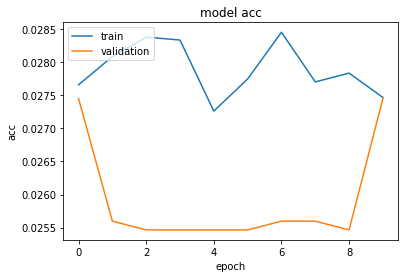

In [37]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()